<a href="https://colab.research.google.com/github/merylmizell/ResNetForCTScans/blob/main/TrainingResNet101V3_Optimized7_w_DataViz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install torch torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.8 MB/s eta 0:00:00
   ━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/664.8 MB 109.7 MB/s eta 0:00:06ERROR: Operation cancelled by user
   ━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/664.8 MB 109.7 MB/s eta 0:00:06


In [ ]:
pip install tensorflow

ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 324, in run
    session = self.get_default_session(options)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/index_command.py", line 71, in get_default_session
    self._session = self.enter_context(self._build_session(options))
                                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/index_command.py", line 100, in _build_session
    session = 

In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from google.colab import drive
import logging
from tqdm import tqdm

# Custom dataset class
class HemorrhageDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image = Image.open(row["png_path"]).convert("RGB")
        image = self.transform(image)
        labels = torch.tensor(row.iloc[1:-1].values, dtype=torch.float32)
        return image, labels

In [3]:
# Define the file paths
csv_files = ["train.csv", "val.csv", "test.csv"]  # Add or remove CSV files as needed
old_path = "C:\\Users\\Myers\\Desktop\\rsna-ihd-dataset_extracted\\rsna-intracranial-hemorrhage-detection\\preprocessed_images\\"
new_path = "/content/drive/MyDrive/preprocessed_images5K/"

for csv_file in csv_files:
    # Load the CSV
    df = pd.read_csv(csv_file)

    # Replace the file paths in the 'png_path' column
    df["png_path"] = df["png_path"].str.replace(old_path, new_path, regex=False)

    # Save the updated CSV file (overwrite or create a new file)
    updated_csv_file = f"updated_{csv_file}"  # Saves as 'updated_train.csv', etc.
    df.to_csv(updated_csv_file, index=False)

    print(f"Updated file saved as: {updated_csv_file}")


Updated file saved as: updated_train.csv
Updated file saved as: updated_val.csv
Updated file saved as: updated_test.csv


In [4]:
# Load data
train_df = pd.read_csv("/content/updated_test.csv")  # Update path
val_df = pd.read_csv("/content/updated_val.csv")
test_df = pd.read_csv("/content/updated_test.csv")

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


In [6]:
# prompt: head of both df

print(train_df.head())
print(val_df.head())
print(test_df.head())


       dicom_id  subdural  epidural  subarachnoid  intraparenchymal  \
0  ID_01241a0ab       0.0       0.0           0.0               0.0   
1  ID_042ab92ef       0.0       0.0           0.0               0.0   
2  ID_03678fae1       0.0       0.0           0.0               0.0   
3  ID_01ed2b6c3       0.0       0.0           0.0               0.0   
4  ID_04e8cccc0       0.0       0.0           0.0               0.0   

   intraventricular  any  none  \
0               0.0  0.0     1   
1               0.0  0.0     1   
2               0.0  0.0     1   
3               0.0  0.0     1   
4               0.0  0.0     1   

                                            png_path  
0  /content/drive/MyDrive/preprocessed_images5K/I...  
1  /content/drive/MyDrive/preprocessed_images5K/I...  
2  /content/drive/MyDrive/preprocessed_images5K/I...  
3  /content/drive/MyDrive/preprocessed_images5K/I...  
4  /content/drive/MyDrive/preprocessed_images5K/I...  
       dicom_id  subdural  epidural  s

In [7]:
class HemorrhageDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = row["png_path"]

        # Load grayscale image
        image = Image.open(image_path).convert("L")  # Convert to grayscale
        image = self.transform(image)

        # Extract labels and handle potential non-numeric values
        labels = row.iloc[1:-1]  # Exclude dicom_id and png_path
        labels = labels.apply(pd.to_numeric, errors='coerce').fillna(0)  # Convert to numeric, replace NaNs with 0
        labels = np.array(labels, dtype=np.float32)  # Convert to float32 NumPy array
        labels = torch.tensor(labels, dtype=torch.float32)  # Convert to PyTorch tensor

        return image, labels

In [8]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [9]:
# Define the correct label columns
label_columns = ['subdural', 'epidural', 'subarachnoid', 'intraparenchymal', 'intraventricular', 'any', 'none']

# Compute label counts
label_counts = train_df[label_columns].sum()
total_samples = len(train_df)

# Calculate pos_weight: inverse of frequency
pos_weights = (total_samples - label_counts) / label_counts
pos_weights = torch.tensor(pos_weights.values, dtype=torch.float32).to(device)

print("Computed pos_weights:", pos_weights)


Computed pos_weights: tensor([ 11.5000, 186.5000,  20.4286,  19.8333,  24.0000,   4.9524,   0.2019],
       device='cuda:0')


In [10]:
# Create dataset and dataloader
train_dataset = HemorrhageDataset(train_df)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Create the validation dataset & DataLoader
val_dataset = HemorrhageDataset(val_df)  # Assuming val_df contains validation data
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)  # Define val_loader

# Create the validation dataset & DataLoader
test_dataset = HemorrhageDataset(test_df)  # Assuming val_df contains validation data
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # Define val_loader

In [11]:
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
# Display sample batch
sample_images, sample_labels = next(iter(train_loader))
print("Sample Batch Shape:", sample_images.shape, sample_labels.shape)


Sample Batch Shape: torch.Size([32, 1, 224, 224]) torch.Size([32, 7])


In [13]:
# Load pre-trained ResNet-151 model
model = models.resnet101(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 180MB/s]


In [14]:
# Modify the first layer to accept 1-channel grayscale images
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

In [15]:
# Modify the last layer to match the number of labels (7 output classes)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 7)  # 7 classes for hemorrhage types


In [16]:
# Move model to GPU (if available)
model = model.to(device)

In [17]:
# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)  # Use BCE for multi-label classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [18]:
#trying a more aggressive decay for more epochs
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

In [33]:
# Initialize all_targets and all_preds as global variables
all_targets = None
all_preds = None

def validate(model, val_loader, criterion, best_thresholds=None):
    global all_targets, all_preds
    model.eval()
    val_loss = 0
    total_correct = [0] * 7
    total_counts = [0] * 7

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            probs = torch.sigmoid(outputs)

            # Apply per-label thresholds if provided, else default to 0.5
            if best_thresholds is not None:
                binary_preds = torch.zeros_like(probs)
                for i, t in enumerate(best_thresholds):
                    binary_preds[:, i] = (probs[:, i] > t).float()
            else:
                binary_preds = (probs > 0.5).float()

            # Accumulate accuracy
            for i in range(7):
                total_correct[i] += (binary_preds[:, i] == labels[:, i]).sum().item()
                total_counts[i] += labels.size(0)

            all_preds.append(binary_preds.cpu())
            all_targets.append(labels.cpu())

    val_loss /= len(val_loader)
    class_accuracies = [100 * c / t if t != 0 else 0 for c, t in zip(total_correct, total_counts)]

    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()

    return val_loss, class_accuracies, all_preds, all_targets


In [34]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [35]:
def optimize_thresholds(model, val_loader, criterion, thresholds=np.arange(0.1, 0.9, 0.1), label_names=None):
    model.eval()
    all_outputs = []
    all_targets = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            all_outputs.append(torch.sigmoid(outputs).cpu())
            all_targets.append(labels.cpu())

    all_outputs = torch.cat(all_outputs).numpy()
    all_targets = torch.cat(all_targets).numpy()

    best_thresholds = []
    best_f1s = []

    print("\n🔎 Optimizing thresholds...\n")
    for class_idx in range(all_outputs.shape[1]):
        best_f1 = 0
        best_thresh = 0.5
        for t in thresholds:
            preds = (all_outputs[:, class_idx] > t).astype(int)
            f1 = f1_score(all_targets[:, class_idx], preds, zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = t

        best_thresholds.append(best_thresh)
        best_f1s.append(best_f1)
        label = label_names[class_idx] if label_names else f"Class {class_idx}"
        print(f"{label:<20} | Best Threshold: {best_thresh:.2f} | F1-score: {best_f1:.3f}")

    return best_thresholds, best_f1s


In [36]:
import json

num_epochs = 16
best_avg_f1 = 0  # Track best average F1 across all labels
best_val_loss = float('inf')  # Track best validation loss


for epoch in range(num_epochs):
    print(f"\n🔁 Starting Epoch {epoch + 1}/{num_epochs}...")
    model.train()
    running_loss = 0.0

    for i, (images, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}", leave=False)):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (i + 1) % 10 == 0:
            logging.info(f"Epoch {epoch + 1}/{num_epochs}, Batch {i + 1}/{len(train_loader)}, Loss: {loss.item():.4f}")

    scheduler.step()
    epoch_loss = running_loss / len(train_loader)

    label_names = ['subdural', 'epidural', 'subarachnoid', 'intraparenchymal',
                   'intraventricular', 'any', 'none']

    # Run validation
    val_loss, class_accuracies, preds, targets = validate(model, val_loader, criterion)

    print(f"\n📉 Validation Loss: {val_loss:.4f}")
    for name, acc in zip(label_names, class_accuracies):
        print(f"{name} Accuracy: {acc:.2f}%")

    print("\n🧮 Classification Report (threshold = 0.5):")
    print(classification_report(targets, preds, target_names=label_names, zero_division=0))

    # Optimize thresholds and evaluate F1
    best_thresholds, best_f1s = optimize_thresholds(model, val_loader, criterion, label_names=label_names)
    avg_f1 = np.mean(best_f1s)

    print("\n🎯 Best per-label thresholds this epoch:")
    for name, thresh, f1 in zip(label_names, best_thresholds, best_f1s):
        print(f"{name:<20} | Threshold: {thresh:.2f} | F1: {f1:.3f}")

    # Save model and thresholds if F1 improves
    if avg_f1 > best_avg_f1:
        best_avg_f1 = avg_f1
        torch.save(model.state_dict(), "best_model_by_f1.pth")
        with open("best_thresholds.json", "w") as f:
            json.dump({name: float(t) for name, t in zip(label_names, best_thresholds)}, f)
        print(f"\n💾 Saved model and thresholds from Epoch {epoch + 1} — Avg F1: {avg_f1:.3f}")

    # Epoch summary
    print(f"✅ Epoch {epoch + 1} done — Avg Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {np.mean(class_accuracies):.2f}%")

    # Optional: Save model by val_loss
    if val_loss < best_val_loss:
         best_val_loss = val_loss
         torch.save(model.state_dict(), "best_model_by_loss.pth")
         logging.info(f"📈 Validation loss improved to {val_loss:.4f} — model saved!")



🔁 Starting Epoch 1/16...



📉 Validation Loss: 0.9743
subdural Accuracy: 65.07%
epidural Accuracy: 61.73%
subarachnoid Accuracy: 73.60%
intraparenchymal Accuracy: 77.47%
intraventricular Accuracy: 78.53%
any Accuracy: 72.40%
none Accuracy: 71.47%

🧮 Classification Report (threshold = 0.5):
                  precision    recall  f1-score   support

        subdural       0.11      0.62      0.19        50
        epidural       0.01      1.00      0.03         4
    subarachnoid       0.12      0.71      0.20        35
intraparenchymal       0.15      0.64      0.25        44
intraventricular       0.15      0.74      0.24        35
             any       0.34      0.71      0.46       123
            none       0.93      0.71      0.81       627

       micro avg       0.35      0.70      0.46       918
       macro avg       0.26      0.73      0.31       918
    weighted avg       0.71      0.70      0.65       918
     samples avg       0.56      0.70      0.61       918


🔎 Optimizing thresholds...

subdural


📉 Validation Loss: 0.9529
subdural Accuracy: 63.73%
epidural Accuracy: 62.13%
subarachnoid Accuracy: 70.53%
intraparenchymal Accuracy: 77.07%
intraventricular Accuracy: 76.53%
any Accuracy: 69.20%
none Accuracy: 68.53%

🧮 Classification Report (threshold = 0.5):
                  precision    recall  f1-score   support

        subdural       0.12      0.74      0.21        50
        epidural       0.01      1.00      0.03         4
    subarachnoid       0.10      0.63      0.17        35
intraparenchymal       0.16      0.70      0.26        44
intraventricular       0.13      0.74      0.23        35
             any       0.32      0.79      0.46       123
            none       0.95      0.66      0.78       627

       micro avg       0.33      0.69      0.44       918
       macro avg       0.26      0.75      0.31       918
    weighted avg       0.71      0.69      0.63       918
     samples avg       0.54      0.67      0.58       918


🔎 Optimizing thresholds...

subdural


📉 Validation Loss: 0.9881
subdural Accuracy: 66.13%
epidural Accuracy: 64.80%
subarachnoid Accuracy: 73.47%
intraparenchymal Accuracy: 77.73%
intraventricular Accuracy: 78.67%
any Accuracy: 70.93%
none Accuracy: 71.47%

🧮 Classification Report (threshold = 0.5):
                  precision    recall  f1-score   support

        subdural       0.12      0.66      0.21        50
        epidural       0.01      1.00      0.03         4
    subarachnoid       0.11      0.66      0.19        35
intraparenchymal       0.17      0.70      0.27        44
intraventricular       0.13      0.63      0.22        35
             any       0.33      0.73      0.45       123
            none       0.93      0.71      0.81       627

       micro avg       0.35      0.71      0.47       918
       macro avg       0.26      0.73      0.31       918
    weighted avg       0.70      0.71      0.65       918
     samples avg       0.57      0.71      0.61       918


🔎 Optimizing thresholds...

subdural


📉 Validation Loss: 0.9647
subdural Accuracy: 68.27%
epidural Accuracy: 64.67%
subarachnoid Accuracy: 73.87%
intraparenchymal Accuracy: 78.40%
intraventricular Accuracy: 78.93%
any Accuracy: 72.40%
none Accuracy: 72.40%

🧮 Classification Report (threshold = 0.5):
                  precision    recall  f1-score   support

        subdural       0.14      0.70      0.23        50
        epidural       0.01      1.00      0.03         4
    subarachnoid       0.12      0.71      0.20        35
intraparenchymal       0.16      0.66      0.26        44
intraventricular       0.14      0.69      0.23        35
             any       0.34      0.71      0.46       123
            none       0.93      0.73      0.82       627

       micro avg       0.36      0.72      0.48       918
       macro avg       0.26      0.74      0.32       918
    weighted avg       0.70      0.72      0.66       918
     samples avg       0.58      0.72      0.62       918


🔎 Optimizing thresholds...

subdural


📉 Validation Loss: 0.9993
subdural Accuracy: 65.47%
epidural Accuracy: 65.73%
subarachnoid Accuracy: 73.47%
intraparenchymal Accuracy: 78.40%
intraventricular Accuracy: 81.07%
any Accuracy: 70.13%
none Accuracy: 70.13%

🧮 Classification Report (threshold = 0.5):
                  precision    recall  f1-score   support

        subdural       0.13      0.72      0.22        50
        epidural       0.02      1.00      0.03         4
    subarachnoid       0.11      0.63      0.18        35
intraparenchymal       0.17      0.70      0.28        44
intraventricular       0.15      0.66      0.24        35
             any       0.32      0.74      0.45       123
            none       0.93      0.69      0.79       627

       micro avg       0.35      0.70      0.47       918
       macro avg       0.26      0.73      0.31       918
    weighted avg       0.71      0.70      0.64       918
     samples avg       0.57      0.69      0.60       918


🔎 Optimizing thresholds...

subdural


📉 Validation Loss: 0.9455
subdural Accuracy: 67.87%
epidural Accuracy: 64.27%
subarachnoid Accuracy: 74.67%
intraparenchymal Accuracy: 80.00%
intraventricular Accuracy: 80.80%
any Accuracy: 73.07%
none Accuracy: 71.87%

🧮 Classification Report (threshold = 0.5):
                  precision    recall  f1-score   support

        subdural       0.13      0.70      0.23        50
        epidural       0.01      1.00      0.03         4
    subarachnoid       0.11      0.60      0.18        35
intraparenchymal       0.18      0.66      0.28        44
intraventricular       0.16      0.74      0.27        35
             any       0.35      0.72      0.47       123
            none       0.93      0.72      0.81       627

       micro avg       0.36      0.71      0.48       918
       macro avg       0.27      0.73      0.32       918
    weighted avg       0.71      0.71      0.66       918
     samples avg       0.57      0.71      0.62       918


🔎 Optimizing thresholds...

subdural


📉 Validation Loss: 1.0235
subdural Accuracy: 68.13%
epidural Accuracy: 66.00%
subarachnoid Accuracy: 75.87%
intraparenchymal Accuracy: 79.33%
intraventricular Accuracy: 80.53%
any Accuracy: 73.87%
none Accuracy: 72.93%

🧮 Classification Report (threshold = 0.5):
                  precision    recall  f1-score   support

        subdural       0.13      0.68      0.22        50
        epidural       0.02      1.00      0.03         4
    subarachnoid       0.12      0.66      0.20        35
intraparenchymal       0.16      0.57      0.24        44
intraventricular       0.14      0.60      0.22        35
             any       0.35      0.70      0.47       123
            none       0.93      0.73      0.82       627

       micro avg       0.37      0.71      0.49       918
       macro avg       0.26      0.71      0.32       918
    weighted avg       0.70      0.71      0.66       918
     samples avg       0.59      0.72      0.63       918


🔎 Optimizing thresholds...

subdural


📉 Validation Loss: 0.9612
subdural Accuracy: 66.00%
epidural Accuracy: 66.00%
subarachnoid Accuracy: 75.07%
intraparenchymal Accuracy: 77.60%
intraventricular Accuracy: 80.00%
any Accuracy: 72.13%
none Accuracy: 71.33%

🧮 Classification Report (threshold = 0.5):
                  precision    recall  f1-score   support

        subdural       0.13      0.72      0.22        50
        epidural       0.02      1.00      0.03         4
    subarachnoid       0.12      0.71      0.21        35
intraparenchymal       0.16      0.64      0.25        44
intraventricular       0.15      0.69      0.24        35
             any       0.34      0.73      0.46       123
            none       0.93      0.71      0.80       627

       micro avg       0.36      0.71      0.47       918
       macro avg       0.26      0.74      0.32       918
    weighted avg       0.71      0.71      0.65       918
     samples avg       0.58      0.71      0.62       918


🔎 Optimizing thresholds...

subdural


📉 Validation Loss: 0.9882
subdural Accuracy: 67.47%
epidural Accuracy: 68.80%
subarachnoid Accuracy: 74.67%
intraparenchymal Accuracy: 80.93%
intraventricular Accuracy: 79.73%
any Accuracy: 72.27%
none Accuracy: 72.00%

🧮 Classification Report (threshold = 0.5):
                  precision    recall  f1-score   support

        subdural       0.13      0.70      0.22        50
        epidural       0.01      0.75      0.03         4
    subarachnoid       0.12      0.69      0.20        35
intraparenchymal       0.18      0.64      0.28        44
intraventricular       0.14      0.63      0.22        35
             any       0.33      0.69      0.45       123
            none       0.92      0.72      0.81       627

       micro avg       0.37      0.71      0.49       918
       macro avg       0.26      0.69      0.32       918
    weighted avg       0.70      0.71      0.66       918
     samples avg       0.58      0.71      0.62       918


🔎 Optimizing thresholds...

subdural


📉 Validation Loss: 1.0145
subdural Accuracy: 66.67%
epidural Accuracy: 66.53%
subarachnoid Accuracy: 74.67%
intraparenchymal Accuracy: 77.73%
intraventricular Accuracy: 80.80%
any Accuracy: 70.40%
none Accuracy: 71.07%

🧮 Classification Report (threshold = 0.5):
                  precision    recall  f1-score   support

        subdural       0.12      0.64      0.20        50
        epidural       0.02      1.00      0.03         4
    subarachnoid       0.11      0.63      0.19        35
intraparenchymal       0.15      0.61      0.24        44
intraventricular       0.15      0.66      0.24        35
             any       0.31      0.66      0.42       123
            none       0.92      0.71      0.81       627

       micro avg       0.35      0.69      0.47       918
       macro avg       0.25      0.70      0.31       918
    weighted avg       0.70      0.69      0.65       918
     samples avg       0.57      0.70      0.61       918


🔎 Optimizing thresholds...

subdural


📉 Validation Loss: 0.9968
subdural Accuracy: 69.07%
epidural Accuracy: 68.67%
subarachnoid Accuracy: 76.93%
intraparenchymal Accuracy: 81.47%
intraventricular Accuracy: 82.27%
any Accuracy: 74.00%
none Accuracy: 74.27%

🧮 Classification Report (threshold = 0.5):
                  precision    recall  f1-score   support

        subdural       0.13      0.64      0.22        50
        epidural       0.01      0.75      0.02         4
    subarachnoid       0.11      0.57      0.19        35
intraparenchymal       0.18      0.61      0.28        44
intraventricular       0.16      0.69      0.27        35
             any       0.35      0.67      0.46       123
            none       0.93      0.75      0.83       627

       micro avg       0.39      0.72      0.50       918
       macro avg       0.27      0.67      0.32       918
    weighted avg       0.71      0.72      0.67       918
     samples avg       0.60      0.73      0.64       918


🔎 Optimizing thresholds...

subdural


📉 Validation Loss: 0.9942
subdural Accuracy: 67.87%
epidural Accuracy: 66.27%
subarachnoid Accuracy: 75.60%
intraparenchymal Accuracy: 80.53%
intraventricular Accuracy: 81.20%
any Accuracy: 73.33%
none Accuracy: 72.40%

🧮 Classification Report (threshold = 0.5):
                  precision    recall  f1-score   support

        subdural       0.12      0.62      0.20        50
        epidural       0.02      1.00      0.03         4
    subarachnoid       0.12      0.66      0.20        35
intraparenchymal       0.18      0.64      0.28        44
intraventricular       0.16      0.71      0.26        35
             any       0.35      0.72      0.47       123
            none       0.93      0.72      0.81       627

       micro avg       0.37      0.71      0.49       918
       macro avg       0.27      0.73      0.32       918
    weighted avg       0.71      0.71      0.66       918
     samples avg       0.58      0.72      0.62       918


🔎 Optimizing thresholds...

subdural


📉 Validation Loss: 0.9932
subdural Accuracy: 67.60%
epidural Accuracy: 66.67%
subarachnoid Accuracy: 76.13%
intraparenchymal Accuracy: 78.40%
intraventricular Accuracy: 80.40%
any Accuracy: 72.67%
none Accuracy: 72.00%

🧮 Classification Report (threshold = 0.5):
                  precision    recall  f1-score   support

        subdural       0.13      0.68      0.22        50
        epidural       0.02      1.00      0.03         4
    subarachnoid       0.12      0.66      0.20        35
intraparenchymal       0.15      0.59      0.24        44
intraventricular       0.15      0.66      0.24        35
             any       0.34      0.69      0.45       123
            none       0.92      0.73      0.81       627

       micro avg       0.37      0.71      0.48       918
       macro avg       0.26      0.71      0.31       918
    weighted avg       0.70      0.71      0.66       918
     samples avg       0.58      0.71      0.62       918


🔎 Optimizing thresholds...

subdural


📉 Validation Loss: 1.0450
subdural Accuracy: 67.73%
epidural Accuracy: 69.73%
subarachnoid Accuracy: 74.27%
intraparenchymal Accuracy: 80.53%
intraventricular Accuracy: 79.47%
any Accuracy: 73.33%
none Accuracy: 73.07%

🧮 Classification Report (threshold = 0.5):
                  precision    recall  f1-score   support

        subdural       0.12      0.62      0.20        50
        epidural       0.01      0.50      0.02         4
    subarachnoid       0.11      0.63      0.19        35
intraparenchymal       0.18      0.66      0.28        44
intraventricular       0.15      0.71      0.25        35
             any       0.35      0.70      0.46       123
            none       0.93      0.74      0.82       627

       micro avg       0.37      0.71      0.49       918
       macro avg       0.26      0.65      0.32       918
    weighted avg       0.70      0.71      0.66       918
     samples avg       0.59      0.72      0.63       918


🔎 Optimizing thresholds...

subdural


📉 Validation Loss: 1.0086
subdural Accuracy: 68.27%
epidural Accuracy: 68.40%
subarachnoid Accuracy: 74.27%
intraparenchymal Accuracy: 79.87%
intraventricular Accuracy: 79.60%
any Accuracy: 71.33%
none Accuracy: 70.93%

🧮 Classification Report (threshold = 0.5):
                  precision    recall  f1-score   support

        subdural       0.13      0.68      0.22        50
        epidural       0.01      0.75      0.02         4
    subarachnoid       0.12      0.71      0.21        35
intraparenchymal       0.18      0.68      0.28        44
intraventricular       0.14      0.66      0.23        35
             any       0.32      0.67      0.44       123
            none       0.92      0.72      0.80       627

       micro avg       0.36      0.70      0.48       918
       macro avg       0.26      0.70      0.32       918
    weighted avg       0.70      0.70      0.65       918
     samples avg       0.58      0.71      0.62       918


🔎 Optimizing thresholds...

subdural


📉 Validation Loss: 1.0516
subdural Accuracy: 68.80%
epidural Accuracy: 69.33%
subarachnoid Accuracy: 74.13%
intraparenchymal Accuracy: 79.20%
intraventricular Accuracy: 78.93%
any Accuracy: 73.20%
none Accuracy: 72.80%

🧮 Classification Report (threshold = 0.5):
                  precision    recall  f1-score   support

        subdural       0.13      0.66      0.22        50
        epidural       0.01      0.75      0.03         4
    subarachnoid       0.10      0.60      0.18        35
intraparenchymal       0.17      0.66      0.27        44
intraventricular       0.14      0.69      0.23        35
             any       0.34      0.67      0.45       123
            none       0.92      0.74      0.82       627

       micro avg       0.37      0.71      0.49       918
       macro avg       0.26      0.68      0.31       918
    weighted avg       0.70      0.71      0.66       918
     samples avg       0.59      0.72      0.63       918


🔎 Optimizing thresholds...

subdural

In [37]:
#just double checking
print(f"Total training images: {len(train_dataset)}")
print(f"Expected number of images: {len(train_df)}")  # Should match 750

sample_images, sample_labels = next(iter(train_loader))

print(f"Image Batch Shape: {sample_images.shape}")  # Should be [batch_size, channels, 224, 224]
print(f"Label Batch Shape: {sample_labels.shape}")  # Should be [batch_size, num_classes]


Total training images: 750
Expected number of images: 750
Image Batch Shape: torch.Size([32, 1, 224, 224])
Label Batch Shape: torch.Size([32, 7])


In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Base model definition
def get_model():
    model = models.resnet101(pretrained=False)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 7)
    return model.to(device)

# Evaluation function
def run_evaluation(model_path, label, thresholds_path="best_thresholds.json"):
    print(f"\n🔍 Evaluating: {label}")

    model = get_model()
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Load thresholds
    with open(thresholds_path, "r") as f:
        threshold_dict = json.load(f)
    best_thresholds = [threshold_dict[label] for label in label_names]

    # Run validation with saved thresholds
    test_loss, class_accuracies, preds, targets = validate(model, test_loader, criterion, best_thresholds=best_thresholds)

    print(f"✅ Test Loss ({label}): {test_loss:.4f}, Avg Accuracy: {np.mean(class_accuracies):.2f}%")
    print("\n📊 Classification Report:")
    print(classification_report(targets, preds, target_names=label_names, zero_division=0))

    return class_accuracies  # Return the accuracies

# Run evaluations and store accuracies
f1_accuracies = run_evaluation("best_model_by_f1.pth", "Saved by F1", "best_thresholds.json")
loss_accuracies = run_evaluation("best_model_by_loss.pth", "Saved by Val Loss", "best_thresholds.json")

# Run both comparisons
#run_evaluation("best_model_by_f1.pth", "Saved by F1", "best_thresholds.json")
#run_evaluation("best_model_by_loss.pth", "Saved by Val Loss", "best_thresholds.json")  # or "best_model_by_loss.pth"


🔍 Evaluating: Saved by F1


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✅ Test Loss (Saved by F1): 0.6251, Avg Accuracy: 86.97%

📊 Classification Report:
                  precision    recall  f1-score   support

        subdural       0.31      0.37      0.34        60
        epidural       0.02      1.00      0.04         4
    subarachnoid       0.28      0.63      0.39        35
intraparenchymal       0.26      0.83      0.39        36
intraventricular       0.34      0.80      0.48        30
             any       0.60      0.60      0.60       126
            none       0.86      0.99      0.92       624

       micro avg       0.58      0.87      0.70       915
       macro avg       0.38      0.75      0.45       915
    weighted avg       0.72      0.87      0.78       915
     samples avg       0.75      0.92      0.80       915


🔍 Evaluating: Saved by Val Loss


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✅ Test Loss (Saved by Val Loss): 0.6197, Avg Accuracy: 87.24%

📊 Classification Report:
                  precision    recall  f1-score   support

        subdural       0.25      0.28      0.27        60
        epidural       0.02      1.00      0.04         4
    subarachnoid       0.29      0.46      0.36        35
intraparenchymal       0.23      0.72      0.35        36
intraventricular       0.43      0.73      0.54        30
             any       0.61      0.56      0.58       126
            none       0.86      0.99      0.92       624

       micro avg       0.59      0.85      0.70       915
       macro avg       0.39      0.68      0.44       915
    weighted avg       0.72      0.85      0.77       915
     samples avg       0.75      0.91      0.80       915



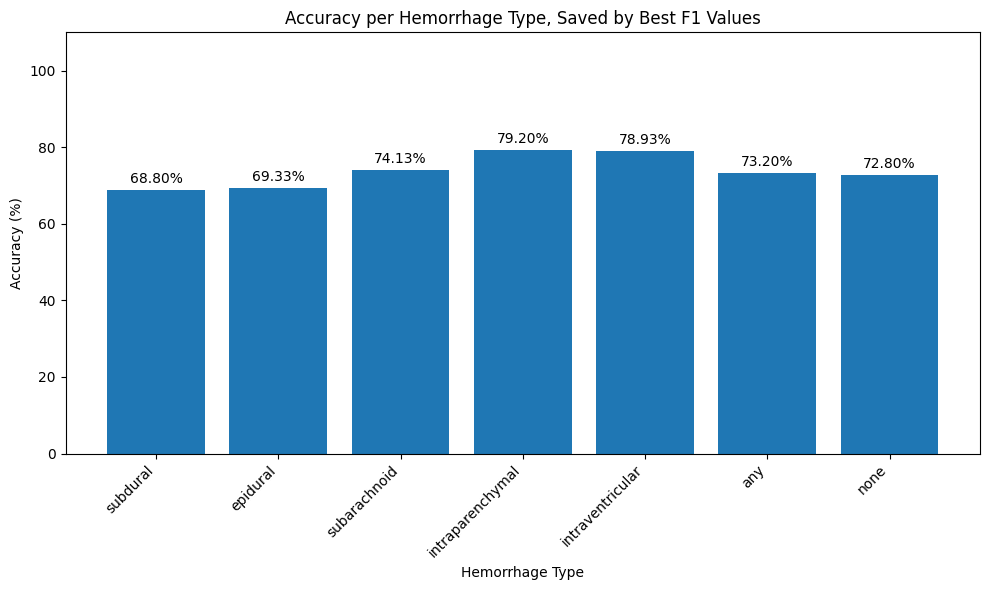

In [41]:
plt.figure(figsize=(10, 6))
bars = plt.bar(label_names, class_accuracies) # Store the bar objects
plt.xlabel("Hemorrhage Type")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy per Hemorrhage Type, Saved by Best F1 Values")
plt.ylim(0, 100 + 10)  # Add extra space for text above bars
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Add percentage text above bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f"{yval:.2f}%", ha='center', va='bottom')

plt.show()


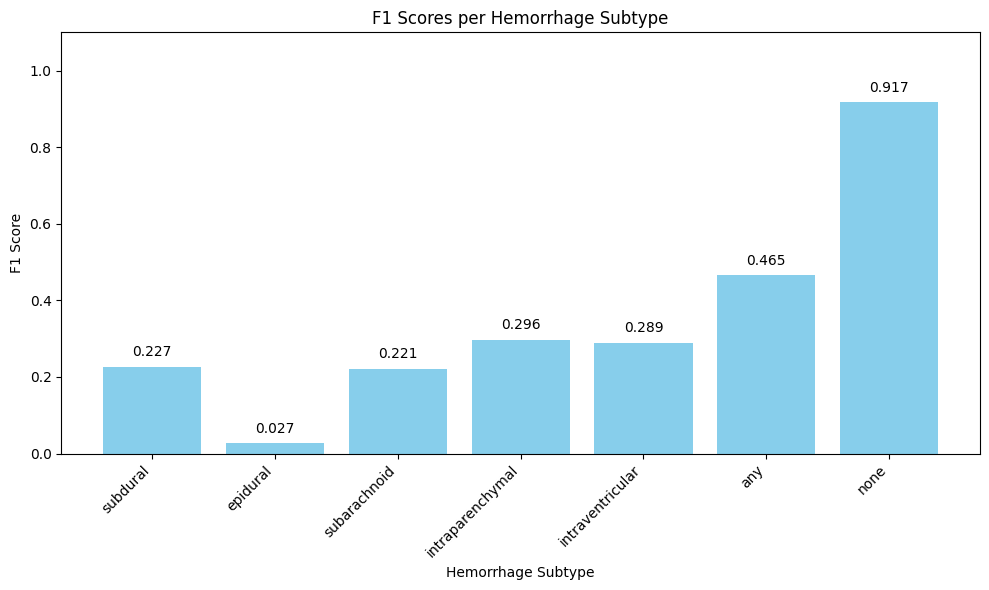

In [42]:
plt.figure(figsize=(10, 6))
bars = plt.bar(label_names, best_f1s, color='skyblue')  # Create bars, you can customize color
plt.xlabel("Hemorrhage Subtype")
plt.ylabel("F1 Score")
plt.title("F1 Scores per Hemorrhage Subtype")
plt.ylim(0, 1.1)  # F1 scores range from 0 to 1, add some space
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability
plt.tight_layout()

# Add F1 score values above the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02,  # Adjust position as needed
             f"{yval:.3f}", ha='center', va='bottom', color='black')

plt.show()

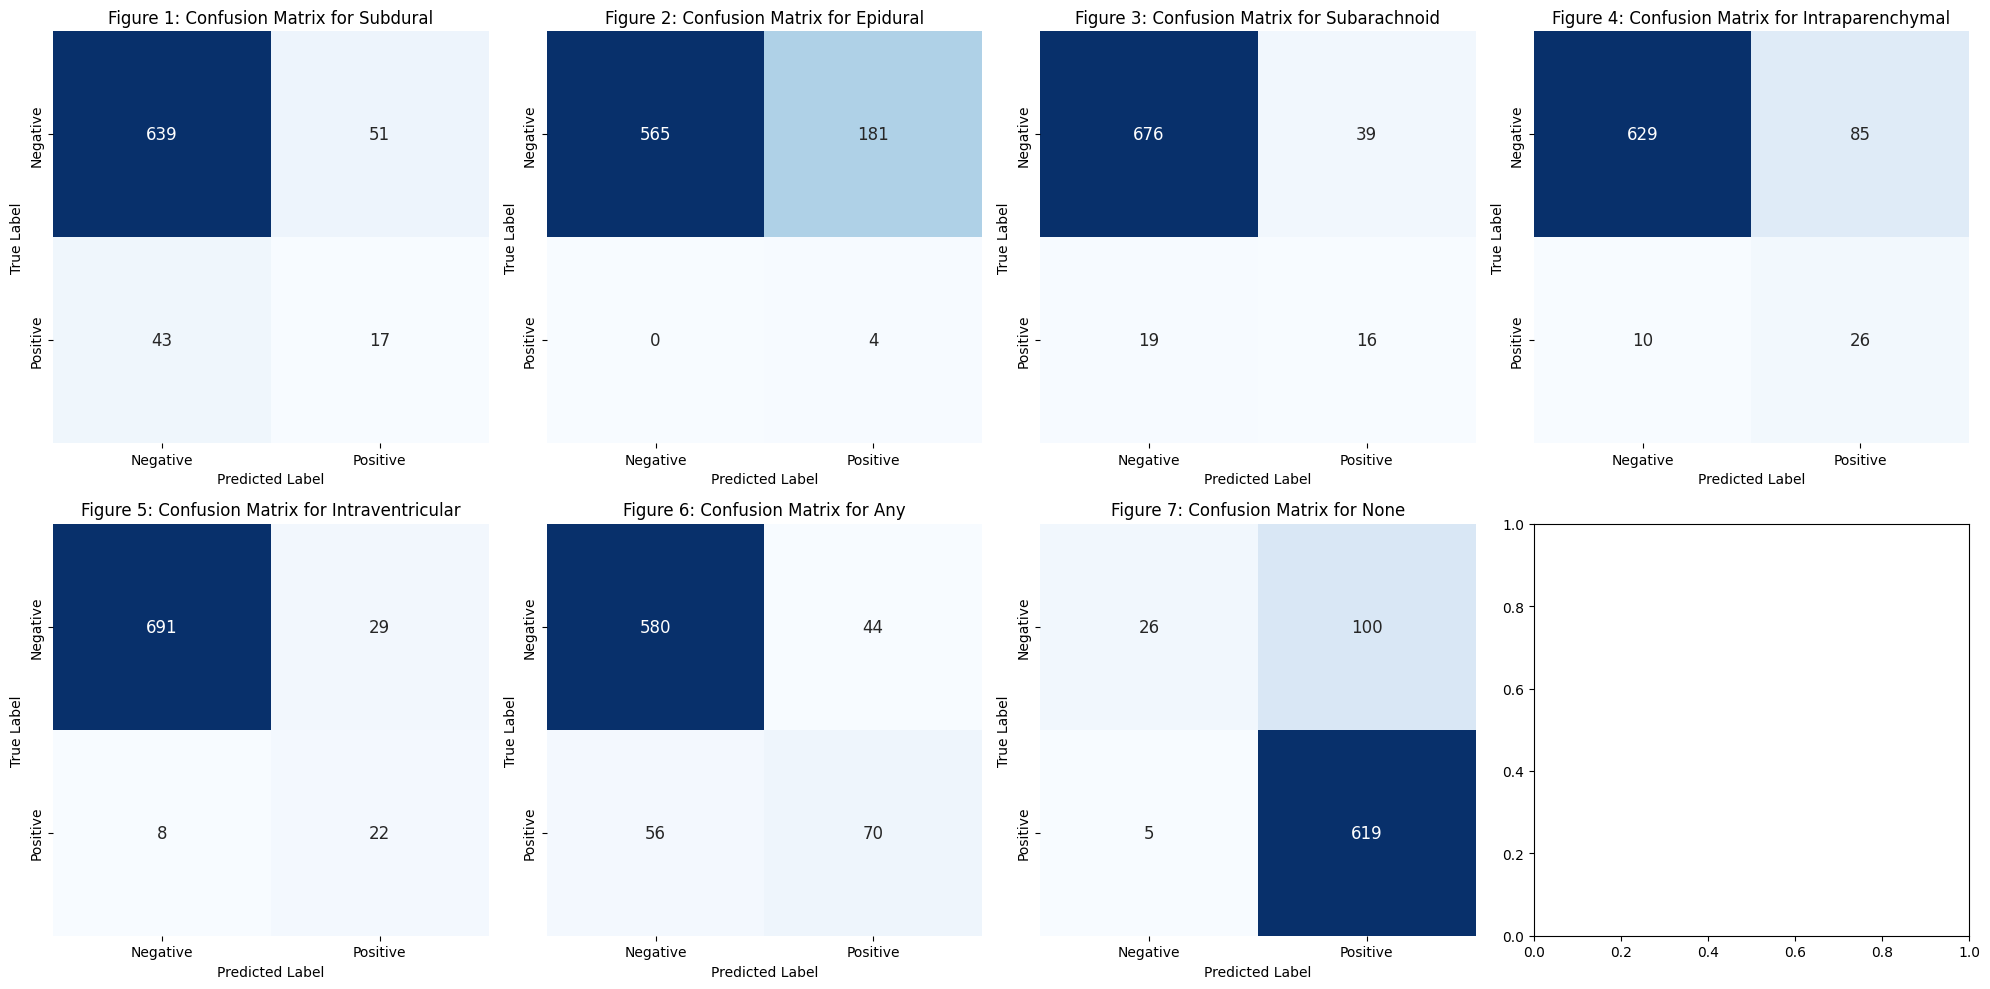

In [46]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
# Calculate confusion matrices for each subtype
cm = multilabel_confusion_matrix(all_targets, all_preds)

# Plot confusion matrices with adjusted figure size and spacing
fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # Increased figure size
axes = axes.ravel()  # Flatten the axes array for easier iteration
plt.subplots_adjust(hspace=0.5, wspace=0.5)  # Add spacing between subplots

for i, (matrix, label) in enumerate(zip(cm, label_names)):
    ax = axes[i]  # Get the current subplot axis
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                ax=ax, annot_kws={"size": 12})  # Customize heatmap appearance
    ax.set_title(f"Figure {i+1}: Confusion Matrix for {label.capitalize()}")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    ax.xaxis.set_ticklabels(['Negative', 'Positive'])
    ax.yaxis.set_ticklabels(['Negative', 'Positive'])

plt.tight_layout()
plt.show()

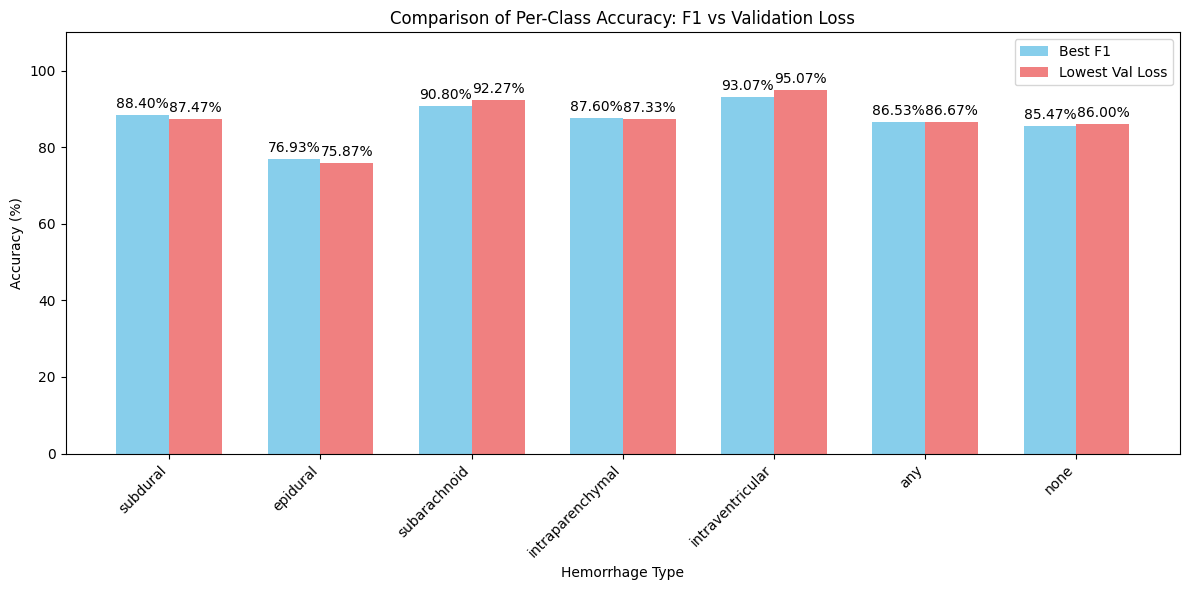

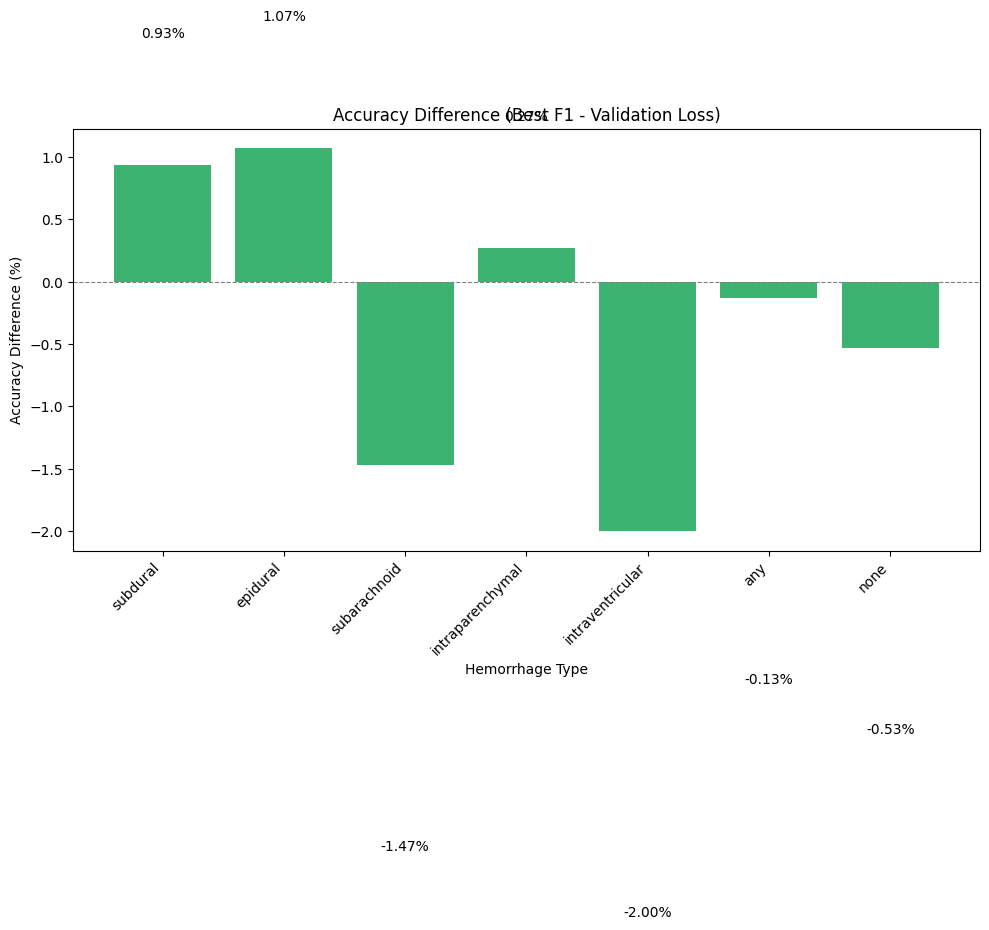

In [44]:
import numpy as np

# Compute differences between F1 and Val Loss accuracies
accuracy_diff = np.array(f1_accuracies) - np.array(loss_accuracies)

# Plot side-by-side bars
x = np.arange(len(label_names))  # label positions
width = 0.35  # bar width

plt.figure(figsize=(12, 6))
bar1 = plt.bar(x - width/2, f1_accuracies, width, label='Best F1', color='skyblue')
bar2 = plt.bar(x + width/2, loss_accuracies, width, label='Lowest Val Loss', color='lightcoral')

plt.xlabel("Hemorrhage Type")
plt.ylabel("Accuracy (%)")
plt.title("Comparison of Per-Class Accuracy: F1 vs Validation Loss")
plt.xticks(x, label_names, rotation=45, ha="right")
plt.ylim(0, 110)
plt.legend()
plt.tight_layout()

# Add values on top of bars
for bar_group in (bar1, bar2):
    for bar in bar_group:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f"{yval:.2f}%", ha='center', va='bottom')

plt.show()

# Plot difference in accuracy
plt.figure(figsize=(10, 6))
bars = plt.bar(label_names, accuracy_diff, color='mediumseagreen')
plt.axhline(0, color='gray', linewidth=0.8, linestyle='--')
plt.xlabel("Hemorrhage Type")
plt.ylabel("Accuracy Difference (%)")
plt.title("Accuracy Difference (Best F1 - Validation Loss)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Add difference values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + (1 if yval >= 0 else -3),
             f"{yval:.2f}%", ha='center', va='bottom' if yval >= 0 else 'top')

plt.show()
